# P5: Segmentez des clients d'un site e-commerce
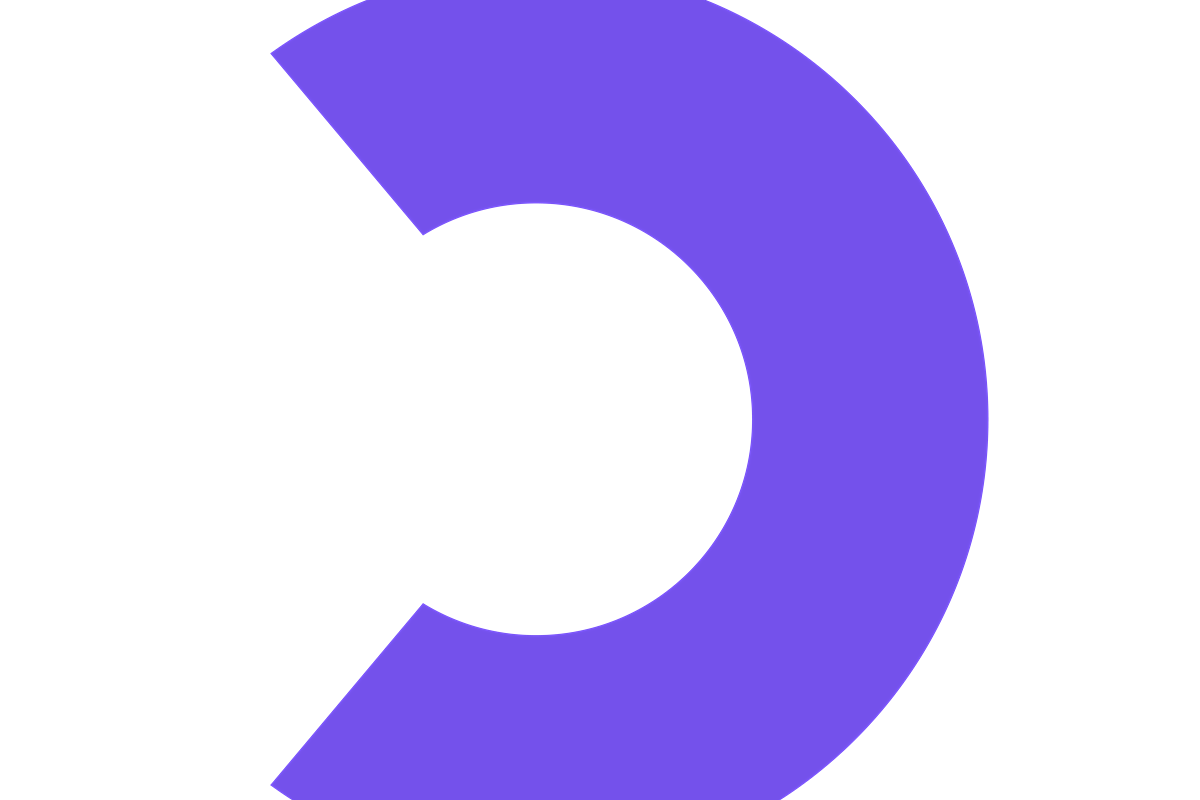

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from utils import *
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn import metrics
import scipy

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"


plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['lines.linewidth'] = 2
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

In [2]:
def aggregate_clients(DF):
    bb_aggregations = {
        'product_id': ['count'], #number of buyed products
        'order_id': ['count'], #number of orders per client
        'payment_type': ['nunique'], # number of payment type
        'payment_type':  lambda x: scipy.stats.mode(x)[0], # payment le plus utilisé par le client
        'payment_value': ['sum'],#, 'mean', 'max'], # La somme totale de payment par client et la moyenne de depesement par client
        'payment_sequential':['max'], # Sequential payment for a customer, what is the maximum number of the payment methods used in one order by the customer
        'payment_installments':['max'], #, 'mean', 'min'], # the maximum, mean and the minimum payment installments per client 
        'review_score': ['max'], #['max', 'min', 'count'], #La score maximale, minimale, et le nombre des scores donné par le client
        'price': ['mean'], #, 'mean', 'max'], #Price total mean, maximum of purcheased per customer
        'freight_value': ['sum'], #, 'max', 'min', 'mean'], # the total sum, the maximum, minimum and the mean for the freight value per customer
        'product_weight_g': ['mean'], #['min', 'mean', 'max' ], # the minimum, mean and the maximum weight in g of prodcuts per customer
        'product_length_cm': ['mean'], #['min', 'mean', 'max'], # the minimum, mean and the maximum length in g of prodcuts per customer
        'product_height_cm': ['mean'], #['min', 'mean', 'max'], # the minimum, mean and the maximum height in g of prodcuts per customer
        'product_width_cm': ['mean'], #['min', 'mean', 'max'], # the minimum, mean and the maximum width in g of prodcuts per customer
        'product_category_name_en':  lambda x: scipy.stats.mode(x)[0], #['mode'] the most used product category name for the customer
        'my_categoty':  lambda x: scipy.stats.mode(x)[0], #the most used product category name for the customer
        #'seller_city': lambda x: scipy.stats.mode(x)[0], # the most used seller city name for the customer
        'customer_state_top10': lambda x: scipy.stats.mode(x)[0],# the customer state name for the customer
        'seller_state_top10': lambda x: scipy.stats.mode(x)[0], # the most used seller state name for the customer
        'geolocation_lat':['mean'], # the mean of geolocalisation latitude per customer
        'geolocation_lng':['mean'], # the mean of geolocalisation longitude per customer
        'diff_car_app':['mean'], # the minimum, mean and the maximum of the difference between the time the order was approved and the time the order was delivered to the logistic partner in days per customer
        'diff_del_car':['mean'], # the minimum, mean and the maximum the time taken between when the order was delivered to the customer after the order was delivered to the logistic partner in days per customer
        'diff_est_act':['mean' ], # the minimum, mean and the maximum the difference between the estimated date of arrival and the actual date of arrival in days per client
        'diff_cust_pur':['mean'], # the minimum, mean and the maximum the difference between the time the order was made and the current date per customer
    }

    DF_result = DF.groupby('customer_unique_id').agg(bb_aggregations)
    col_name = pd.Index([e[0] + "_" + e[1].upper().replace('<', '').replace('>', '') for e in DF_result.columns.tolist()])
    DF_result.columns = col_name

    DF_result = DF_result.reset_index()
    
    return DF_result

In [3]:
df = pd.read_csv('data/df.csv')

In [4]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchease_year,diff_app_pur,...,my_categoty,seller_zip_code_prefix,seller_city,seller_state,seller_state_top10,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,2017,0,...,dressing,9350,maua,SP,SP,3149,-23.574809,-46.587471,sao paulo,SP
1,70b35acffdf851e782ebf6fbc35eb620,8e8ee9b08afb49b080d193f98b0505af,delivered,2018-03-22,2018-03-22,2018-03-23,2018-03-25,2018-04-04,2018,0,...,home_layout,13405,piracicaba,SP,SP,3149,-23.574809,-46.587471,sao paulo,SP
2,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04,2017-09-04,2017-09-04,2017-09-05,2017-09-15,2017,0,...,baby,7025,guarulhos,SP,SP,3149,-23.574809,-46.587471,sao paulo,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17,2017-08-18,2017-08-28,2017,0,...,dressing,9350,maua,SP,SP,3366,-23.565578,-46.534603,sao paulo,SP
4,ded23d37cdcc25b37b4473b7be770cb2,f96144f946e8e590fabf60a3a1e3342e,delivered,2018-07-26,2018-07-27,2018-08-02,2018-08-07,2018-08-20,2018,0,...,furniture,37564,borda da mata,MG,MG,3366,-23.565578,-46.534603,sao paulo,SP


In [5]:
df.customer_unique_id

0        7c396fd4830fd04220f754e42b4e5bff
1        8a4002923e801e3120a11070fd31c9e2
2        7c396fd4830fd04220f754e42b4e5bff
3        3a51803cc0d012c3b5dc8b7528cb05f7
4        806ab9e6d7c897da7e3b6104dadadc34
                       ...               
98383    f415ac637291d7774a3bf274b8b33fd0
98384    5ede9beb1608cb450626b3c83db9f8ec
98385    a1644581211b1c1d4933064a411ad7de
98386    34f2ec40e13a7f433b8ef0aa77426e77
98387    17cb19c8526583b203e7a3a6c828d3aa
Name: customer_unique_id, Length: 98388, dtype: object

***Set the year and the mounth in the data***

In [6]:
df.loc[:, 'month'] = pd.to_datetime(df.order_purchase_timestamp).dt.month

In [7]:
df.loc[:, 'year'] = pd.to_datetime(df.order_purchase_timestamp).dt.year

In [8]:
df.loc[:, 'day'] = pd.to_datetime(df.order_purchase_timestamp).dt.day

In [9]:
conditions = [
    (df['day'] <= 15),
    (df['day'] > 15)
    ]

# create a list of the values we want to assign for each condition
values = [1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
df['month_part'] = np.select(conditions, values)

***What are the purchease years in oud dataset?***

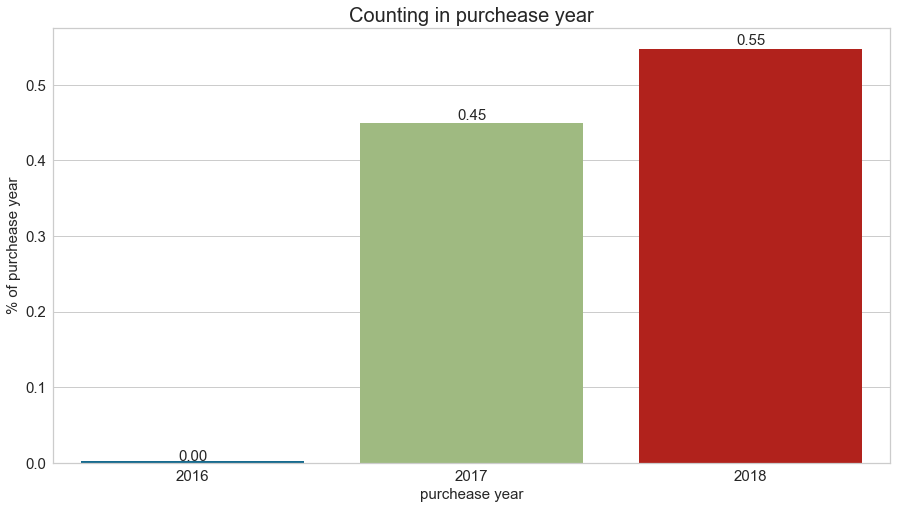

In [10]:
plot_count_col(df, col= 'year', label_col='purchease year', show_val=True)

***What months we have in 2016? And what are their repartitions?***

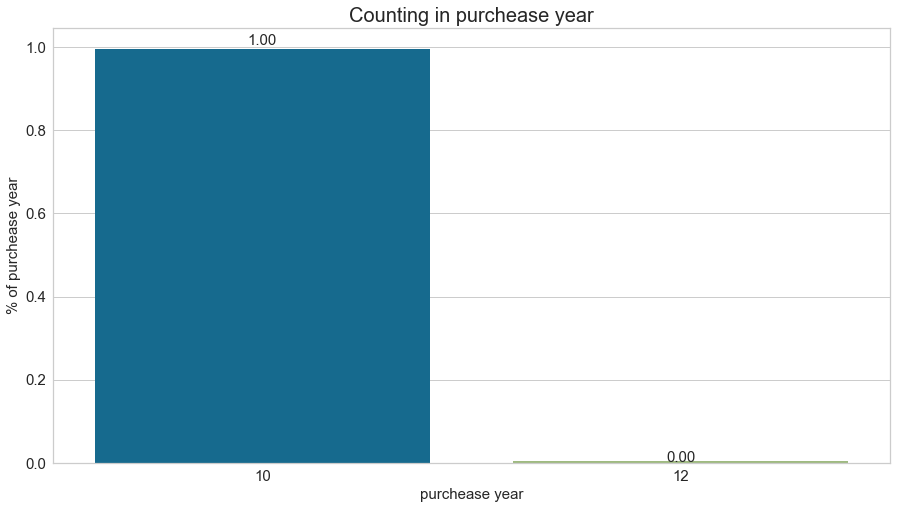

In [11]:
plot_count_col(df[df.year==2016], col= 'month', label_col='purchease year', show_val=True)

***What months we have in 2017? And what are their repartitions?***

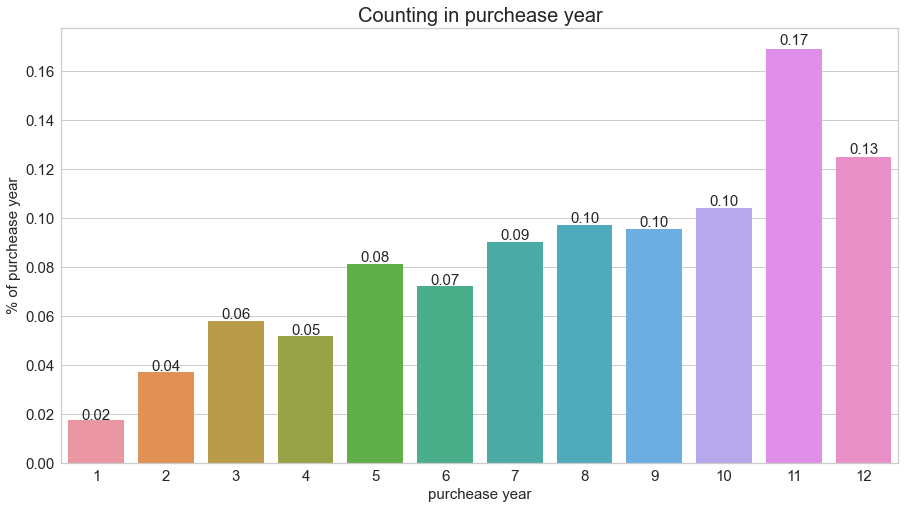

In [12]:
plot_count_col(df[df.year==2017], col= 'month', label_col='purchease year', show_val=True)

***What months we have in 2018? And what are their repartitions?***

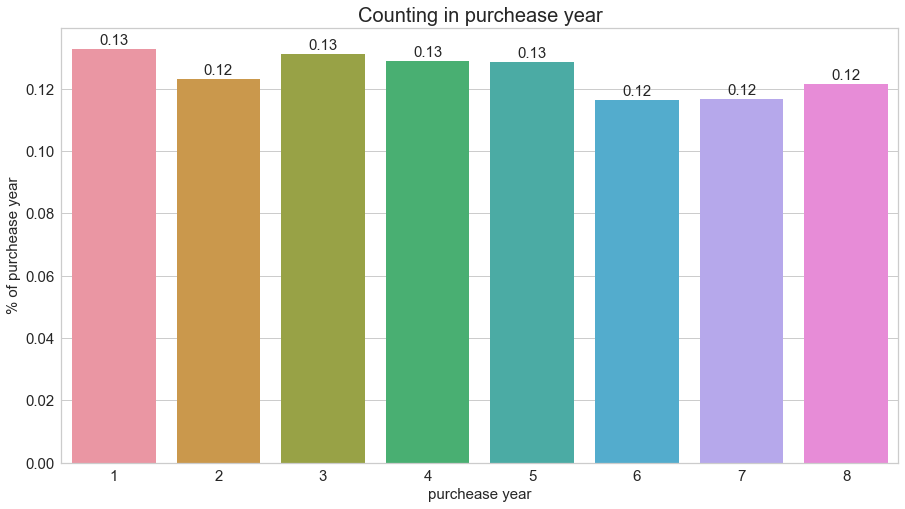

In [13]:
plot_count_col(df[df.year==2018], col= 'month', label_col='purchease year', show_val=True)

***And what are their repartitions of mounths for all the years?***

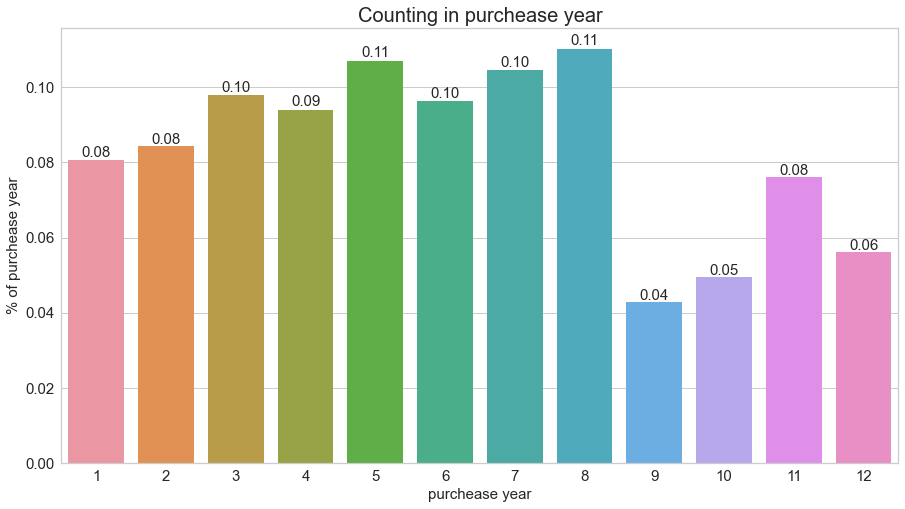

In [14]:
plot_count_col(df, col= 'month', label_col='purchease year', show_val=True)

We take all the data and train the model on each mounth. Then the ARI is compared.

In [15]:
is_poly = False # try on data with polynomial variables
is_only_num = False # try on data with numerical variables
is_pca = True # do we apply pca?

In [16]:
def preprocessing_dfclients(DF, is_poly, is_only_num, is_pca):
    DF = DF.drop(["customer_unique_id"], axis=1)
    
    if is_poly:
        df_clients_corr = DF.corr()
        DF = remove_columns_regarding_correlation(DF, df_clients_corr, hdc_make=False, hc_make=True)
    else:
        columns_of_interest = ['product_id_COUNT',
                            #'payment_type_LAMBDA',
                            'payment_value_SUM',
                            #'payment_sequential_MAX',
                            #'payment_installments_MAX',
                            'review_score_MAX',
                            'price_MEAN',
                            #'freight_value_SUM',
                            #'product_weight_g_MEAN',
                            #'product_length_cm_MEAN',
                            #'product_height_cm_MEAN',
                            #'product_width_cm_MEAN',
                            #'product_category_name_en_LAMBDA',
                            'my_categoty_LAMBDA',
                            #'customer_state_top10_LAMBDA',
                            #'seller_state_top10_LAMBDA',
                            'geolocation_lat_MEAN',
                            'geolocation_lng_MEAN',
                            #'diff_car_app_MEAN',
                            #'diff_del_car_MEAN',
                            #'diff_est_act_MEAN',
                            'diff_cust_pur_MEAN']
        DF = DF[columns_of_interest]

    if is_only_num:
        num_cols = DF._get_numeric_data().columns
        DF = DF[num_cols]

    # Encoding
    if is_only_num==False:
        DF, new_columns = encode_categorical_variables(DF, nan_as_category = True)
        df_clients_encoded_corr = DF.corr()
        DF = remove_columns_regarding_correlation(DF, df_clients_encoded_corr, hdc_make=False, hc_make=True)

    # Normalization
    std_scale = preprocessing.RobustScaler().fit(DF) #preprocessing.MinMaxScaler, StandardScaler RobustScaler
    DF = pd.DataFrame(std_scale.transform(DF), columns=DF.columns)

    # Dimenison Reduction
    pca_features_ratio = {}
    '''
    explained_by_pca = 0.95
    is_not_selected=True
    if is_pca:
        pca = PCA(random_state=10)
        pca.fit(DF)
        for k in range(DF.shape[1]):
            s = np.cumsum(pca.explained_variance_ratio_)[k]
            pca_features_ratio[k] = s
            if ((s>=explained_by_pca) & is_not_selected):
                n_comp = k
                is_not_selected = False
    '''

    # Calcul des composantes principales
    if is_pca:
        n_comp = 7
        colonnes_pca = DF.columns
        pca = decomposition.PCA(n_components=n_comp, random_state=10)
        pca.fit(DF)
        X_projected = pca.fit_transform(DF)
        X_projected = pd.DataFrame(X_projected, index = DF.index, columns = ['F{0}'.format(i) for i in range(n_comp)])
    
    return DF


***Setting the number of cluesters***

In [17]:
K=5

Taking dfi = df1 + all months from 1 to the i-th mounth, thus the dfi dataset contains the first month, the second mounth..... till the ith mounth

In [18]:
ari_dict = {}

# take the first month clients data
df_clients = aggregate_clients(df[(df.year == 2017) & (df.month > 6)]) # the last 6 months from year 2017
df_clients = preprocessing_dfclients(df_clients, is_poly=False, is_only_num=True, is_pca=True)

# fit the model on the first month of clients
kmeans_1 = KMeans(n_clusters=K, random_state=10, init='k-means++', n_init=10, max_iter=1500).fit(df_clients) # fit on clients of the last 6 months from 2017

for month in range(1, 9):
    with timer("month {0}".format(month)):
        selected_clients = aggregate_clients(df[(df.year == 2018) & (df.month == month)]) # 
        selected_clients = preprocessing_dfclients(selected_clients, is_poly=False, is_only_num=True, is_pca=True) # clients per month from 2018
        
        df_clients2 = aggregate_clients(df[(df.year == 2018) & (df.month <= month)]) # 
        df_clients2 = preprocessing_dfclients(df_clients2, is_poly=False, is_only_num=True, is_pca=True)

        kmeans_2 = KMeans(n_clusters=K, random_state=10, init='k-means++', n_init=10, max_iter=1500).fit(df_clients2)

        clusters1 = kmeans_2.predict(selected_clients) # use the model trained on the last 6 mounths 2017 plus the (1st month to current ’month) and make prediction on one month from 2018
        clusters2 = kmeans_1.predict(selected_clients) # use the model trained on the last month of 2018 and make prediction on one month from 2018

        ari_dict[month] = metrics.adjusted_rand_score(clusters1 , clusters2)
    

month 1 - done in 4s
month 2 - done in 5s
month 3 - done in 7s
month 4 - done in 9s
month 5 - done in 12s
month 6 - done in 12s
month 7 - done in 14s
month 8 - done in 15s


In [19]:
aripd = pd.DataFrame.from_dict(ari_dict.items())
aripd.columns=['month', 'ari score']

In [20]:
aripd

,month,ari score
0,1,0.944850
1,2,0.488853
2,3,0.473600
3,4,0.464901
4,5,0.919489
5,6,0.943702
6,7,0.951196
7,8,0.913185


Text(0.5, 1.0, 'Temporal stability for KMeans')

<AxesSubplot:title={'center':'Temporal stability for KMeans'}, xlabel='month', ylabel='ari score'>

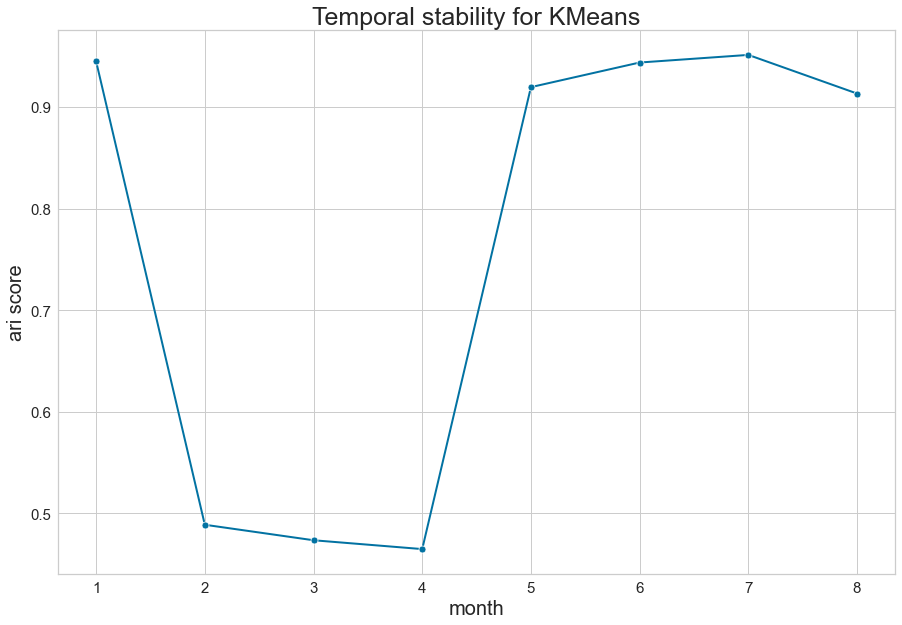

In [22]:
plt.title('Temporal stability for KMeans',fontsize=25);
sns.lineplot(data=aripd, x="month", y="ari score", marker='o')

In [23]:
ari_dict = {}

# take the first month clients data
df_clients = aggregate_clients(df[(df.year == 2017) & (df.month > 11)]) # the last 6 months from year 2017
df_clients = preprocessing_dfclients(df_clients, is_poly=False, is_only_num=True, is_pca=True)

# fit the model on the first month of clients
kmeans_1 = KMeans(n_clusters=K, random_state=10, init='k-means++', n_init=10, max_iter=1500).fit(df_clients) # fit on clients of the last 6 months from 2017

for month in range(1, 9):
    for m_part in range(1, 3): # first 15 days is 1, second part of mounth is 2
        with timer("month {0}".format(month)):
            selected_clients = aggregate_clients(df[(df.year == 2018) & (df.month == month) & (df.month_part == m_part)]) # 
            selected_clients = preprocessing_dfclients(selected_clients, is_poly=False, is_only_num=True, is_pca=True) # clients per month from 2018
            
            if m_part == 2:
                df_clients2 = aggregate_clients(df[(df.year == 2018) & (df.month <= month)]) # 
                df_clients2 = preprocessing_dfclients(df_clients2, is_poly=False, is_only_num=True, is_pca=True)
            elif m_part == 1:
                df_clients2_p1 = aggregate_clients(df[(df.year == 2018) & (df.month <= month-1)]) # 
                df_clients2_p2 = aggregate_clients(df[(df.year == 2018) & (df.month == month) & (df.month_part == m_part)]) # 
                df_clients2 = pd.concat([df_clients2_p1, df_clients2_p2], axis=0)
                df_clients2 = preprocessing_dfclients(df_clients2, is_poly=False, is_only_num=True, is_pca=True)

            kmeans_2 = KMeans(n_clusters=K, random_state=10, init='k-means++', n_init=10, max_iter=1500).fit(df_clients2)

            clusters1 = kmeans_2.predict(selected_clients) # use the model trained on the  (1st month part to the current ’month part) and make prediction on one month part from 2018
            clusters2 = kmeans_1.predict(selected_clients) # use the model trained on the last mounth 2017 and make prediction on one month part from 2018

            ari_dict[month, m_part] = metrics.adjusted_rand_score(clusters1 , clusters2)
    

month 1 - done in 2s
month 1 - done in 3s
month 2 - done in 4s
month 2 - done in 5s
month 3 - done in 6s
month 3 - done in 7s
month 4 - done in 7s
month 4 - done in 8s
month 5 - done in 9s
month 5 - done in 10s
month 6 - done in 11s
month 6 - done in 11s
month 7 - done in 12s
month 7 - done in 13s
month 8 - done in 14s
month 8 - done in 14s


In [24]:
ari_dict

{(1, 1): 0.9521179027142498,
 (1, 2): 0.9695436801133369,
 (2, 1): 0.9731119675785066,
 (2, 2): 0.6700717096153792,
 (3, 1): 0.5948569355434543,
 (3, 2): 0.5254742637666346,
 (4, 1): 0.479463537478196,
 (4, 2): 0.48438545870098265,
 (5, 1): 0.9301686258919736,
 (5, 2): 0.9062669665105786,
 (6, 1): 0.9279589722714339,
 (6, 2): 0.9021047795398801,
 (7, 1): 0.937403174309743,
 (7, 2): 0.9340233247506224,
 (8, 1): 0.9277719662534233,
 (8, 2): 0.9234457926678563}

In [25]:
aripd = pd.DataFrame.from_dict(ari_dict.items())
aripd.columns=['mounth', 'ari score']
aripd.loc[:, 'months'] = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6,6.5,7,7.5,8,8.5]

In [26]:
aripd.index

RangeIndex(start=0, stop=16, step=1)

In [27]:
aripd

,mounth,ari score,months
0,"(1, 1)",0.952118,1.0
1,"(1, 2)",0.969544,1.5
2,"(2, 1)",0.973112,2.0
3,"(2, 2)",0.670072,2.5
4,"(3, 1)",0.594857,3.0
5,"(3, 2)",0.525474,3.5
6,"(4, 1)",0.479464,4.0
7,"(4, 2)",0.484385,4.5
8,"(5, 1)",0.930169,5.0
9,"(5, 2)",0.906267,5.5


Text(0.5, 1.0, 'Temporal stability for KMeans')

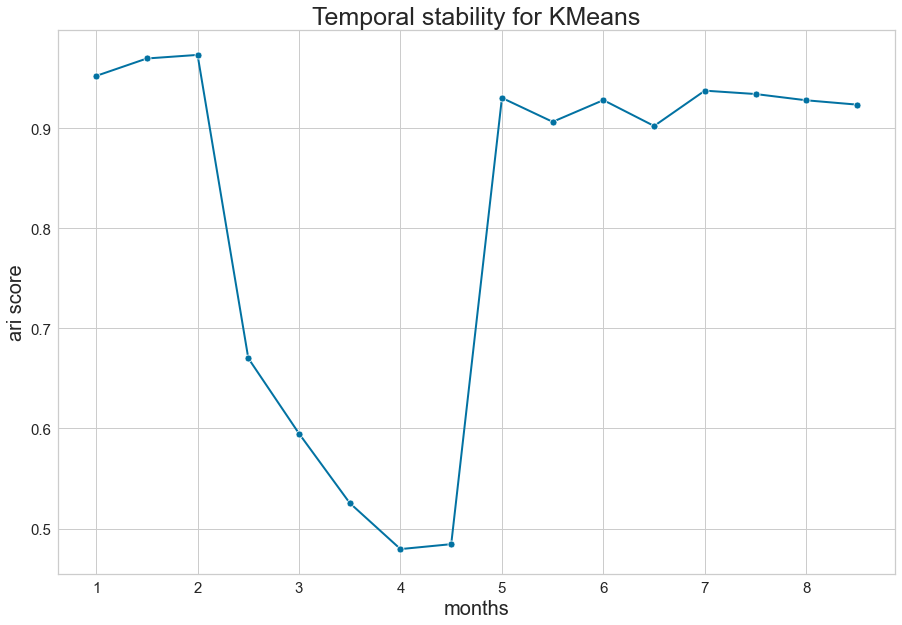

In [28]:
plt.title('Temporal stability for KMeans',fontsize=25);
ax = sns.lineplot(data=aripd, x="months", y="ari score", marker='o')

Observe in this plot that the ari score will fall down starting with the 2 mounth and a half, therewhy it is necessary to learn the model once in 2 mounth to be sure that model is well trained.